In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/adityajn105/flickr30k


## Part 1: Feature Extraction Pipeline (Mandatory)

In [2]:
import os
import re
from collections import Counter
import pickle
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

In [3]:
m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# m = nn.Sequential(*list(m.children())[:-1])  # Feature vector only

summary(m, input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s] 


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [4]:
def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input/'

    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root

    return None


IMAGE_DIR = find_image_dir()
OUTPUT_FILE = '/kaggle/working/flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError(
        "Could not find the Flickr30k image directory. Please ensure the dataset "
        "is added to the notebook."
    )


# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [
            f for f in os.listdir(img_dir)
            if f.endswith(('.jpg', '.jpeg'))
        ]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)

        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")


 Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images


Extracting Features: 100%|██████████| 249/249 [01:57<00:00,  2.13it/s]


Success! 31783 images processed and saved to /kaggle/working/flickr30k_features.pkl


In [9]:
model

DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

## Part 2: Vocabulary & Text Pre-Processing

In [6]:
ImgToCap = {}

CAP_FILE = '/kaggle/input/datasets/adityajn105/flickr30k/captions.txt'

with open(CAP_FILE, 'r') as f:
    next(f)
    caption_doc = f.read()

for line in tqdm(caption_doc.split('\n')):
    line = line.strip()
    if not line:
        continue
        
    tokens = line.split(',')
    

    imgId, caption = tokens[0], tokens[1:]
    imgId = imgId.split('.')[0]
    caption = " ".join(caption)

    if imgId not in ImgToCap:
        ImgToCap[imgId] = []

    ImgToCap[imgId].append(caption)

100%|██████████| 158916/158916 [00:00<00:00, 823619.41it/s]


In [7]:
# Text Pre-Processing
def clean(ImgToCap):
    for key, captions in ImgToCap.items():
        for i in range(len(captions)):
            # Take one at a time
            caption = captions[i]
            # Clean Text
            caption = caption.lower()
            
            caption = re.sub(r'[^A-Za-z\s]', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Add Tags
            caption = '<start> ' + caption + ' <end>'

            captions[i] = caption

In [12]:
# Before Cleaning
ImgToCap['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '" Two young   White males are outside near many bushes ."',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

In [42]:
clean(ImgToCap)

In [14]:
# After Cleaning
ImgToCap['1000092795']

['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start> two young white males are outside near many bushes <end>',
 '<start> two men in green shirts are standing in a yard <end>',
 '<start> a man in a blue shirt standing in a garden <end>',
 '<start> two friends enjoy time spent together <end>']

In [8]:
all_captions = []

for key in ImgToCap.keys():
    for c in ImgToCap[key]:
        all_captions.append(c)

In [79]:
START = "<start>"
END = "<end>"
PAD = "<pad>"
UNK = "<unk>"

In [43]:
from collections import Counter

counter = Counter()

for caps in ImgToCap.values():
    for c in caps:
        counter.update(c.split())

min_freq = 5   # try 3 or 5

vocab = ["<pad>", "<unk>"] + [
    word for word, count in counter.items()
    if count >= min_freq
]

stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

vocab_size = len(vocab)

print("New vocab size:", vocab_size)


New vocab size: 7689


In [50]:
print(
    "<end>" in vocab,
    "<start>" in vocab,
    "<pad>" in vocab,
    "<unk>" in vocab
)

True True True True


In [45]:
ImgToCap["1000092795"]

['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start> two young white males are outside near many bushes <end>',
 '<start> two men in green shirts are standing in a yard <end>',
 '<start> a man in a blue shirt standing in a garden <end>',
 '<start> two friends enjoy time spent together <end>']

In [18]:
# Testing stoi and itos
stoi["man"]

32

In [19]:
itos[32]

'man'

In [11]:
def numericalize(caption):
    return torch.tensor([stoi.get(t, stoi["<unk>"]) for t in caption.split()])

In [12]:
numericalize('<start> two friends enjoy time spent together <end>')

tensor([  1, 131,  38,  39,  40,  41,  42,   1])

In [13]:
numericalize('<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>')

tensor([  1, 131,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,   1])

In [52]:
vocab_size = len(vocab)

print(f'vocab size: {vocab_size}')

vocab size: 7689


In [51]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, ids, ImgToCap, features_dict):
        self.samples = []
        
        for img_id in ids:
            for cap in ImgToCap[img_id]:
                self.samples.append((img_id, cap))

        self.features = features_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, caption = self.samples[idx]

        if img_id == '':
            print("FOUND EMPTY IMG_ID AT IDX:", idx, caption)
            
        try:
            feat = torch.tensor(self.features[img_id + ".jpg"]).float()
        except KeyError as e:
            print("\n--- KEY ERROR DEBUG ---")
            print("IDX:", idx)
            print("RAW img_id repr:", repr(img_id))
            print("img_id + .jpg:", repr(img_id + ".jpg"))
            print("Available example keys:", list(self.features.keys())[:5])
            print("-----------------------\n")
            raise e
            
        cap_ids = numericalize(caption)

        return feat, cap_ids

In [53]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    feats, caps = zip(*batch)

    feats = torch.stack(feats)

    caps_in = [c[:-1] for c in caps]
    caps_out = [c[1:] for c in caps]

    caps_in = pad_sequence(caps_in, batch_first=True, padding_value=stoi[PAD])
    caps_out = pad_sequence(caps_out, batch_first=True, padding_value=stoi[PAD])

    return feats, caps_in, caps_out

In [54]:
# Train Test Split
image_ids = list(ImgToCap.keys())
split = int( (len(image_ids) * 0.9) )
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [22]:
train_ids[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [29]:
list(ImgToCap.items())[:5]

[('1000092795',
  [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
   '" Two young   White males are outside near many bushes ."',
   ' Two men in green shirts are standing in a yard .',
   ' A man in a blue shirt standing in a garden .',
   ' Two friends enjoy time spent together .']),
 ('10002456',
  [' Several men in hard hats are operating a giant pulley system .',
   ' Workers look down from up above on a piece of equipment .',
   ' Two men working on a machine wearing hard hats .',
   ' Four men on top of a tall structure .',
   ' Three men on a large rig .']),
 ('1000268201',
  [' A child in a pink dress is climbing up a set of stairs in an entry way .',
   ' A little girl in a pink dress going into a wooden cabin .',
   ' A little girl climbing the stairs to her playhouse .',
   ' A little girl climbing into a wooden playhouse',
   ' A girl going into a wooden building .']),
 ('1000344755',
  [' Someone in a blue shirt and hat is standing

In [31]:
list(features_dict.items())[:5]

[('2715746315.jpg',
  array([0.33279228, 0.05021076, 0.        , ..., 0.006649  , 0.04138336,
         0.10314237], dtype=float32)),
 ('3463034205.jpg',
  array([1.1876303 , 0.02653548, 0.15240808, ..., 0.06427108, 0.        ,
         0.45025933], dtype=float32)),
 ('268704620.jpg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)),
 ('2673564214.jpg',
  array([0.00612751, 0.        , 0.2899485 , ..., 0.02514903, 0.        ,
         0.1699426 ], dtype=float32)),
 ('7535037918.jpg',
  array([0.        , 0.01933213, 0.0036334 , ..., 0.11248922, 0.        ,
         0.04654112], dtype=float32))]

In [55]:
sum((v == 0).all() for v in features_dict.values())

np.int64(0)

In [56]:
train_loader = DataLoader(
    CaptionDataset(train_ids, ImgToCap, features_dict),
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    CaptionDataset(test_ids, ImgToCap, features_dict),
    batch_size=128,
    shuffle=False,
    collate_fn=collate_fn
)

## Part 3: Seq2Seq Arch

In [57]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim=2048, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))
        

In [58]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512):
        super().__init__()

        self.embed = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=stoi[PAD]
        )

        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, captions, hidden):
        # Embedding
        emb = self.embed(captions)

        # Dropout on embeddings
        emb = self.dropout(emb)

        outputs, hidden = self.lstm(emb, hidden)

        outputs = self.dropout(outputs)

        # Final vocabulary projection
        logits = self.fc(outputs)

        return logits, hidden


In [59]:
class ImageCaptionModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(vocab_size)

    def forward(self, feats, captions):
        h0 = self.encoder(feats).unsqueeze(0)
        c0 = torch.zeros_like(h0)

        outputs, _ = self.decoder(captions, (h0, c0))
        return outputs


## Part 4: Training & Inference

In [30]:
stoi["<pad>"]

0

In [60]:
model = ImageCaptionModel(vocab_size)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=stoi[PAD])

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)


Using 2 GPUs


In [61]:
def train_epoch(loader):
    model.train()
    total_loss = 0

    for feats, caps_in, caps_out in loader:
        feats, caps_in, caps_out = feats.to(device), caps_in.to(device), caps_out.to(device)

        optimizer.zero_grad()
        outputs = model(feats, caps_in)

        loss = criterion(
            outputs.reshape(-1, vocab_size),
            caps_out.reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [33]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0

    with torch.set_grad_enabled(train):
        for feats, caps_in, caps_out in loader:
            feats = feats.to(device)
            caps_in = caps_in.to(device)
            caps_out = caps_out.to(device)

            outputs = model(feats, caps_in)

            loss = criterion(
                outputs.reshape(-1, vocab_size),
                caps_out.reshape(-1)
            )

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

    return total_loss / len(loader)


In [34]:
features_dict.keys()

dict_keys(['2715746315.jpg', '3463034205.jpg', '268704620.jpg', '2673564214.jpg', '7535037918.jpg', '4912369161.jpg', '4828071602.jpg', '6802728196.jpg', '3346289227.jpg', '3217056901.jpg', '272471327.jpg', '4717261252.jpg', '4763916790.jpg', '2700788458.jpg', '2795287622.jpg', '4453893059.jpg', '2094323311.jpg', '2375770917.jpg', '5962278982.jpg', '2460568004.jpg', '2567962271.jpg', '4569787426.jpg', '2782433864.jpg', '4571040008.jpg', '7616312438.jpg', '4905053758.jpg', '3533922605.jpg', '4532518749.jpg', '3397633339.jpg', '4544052868.jpg', '3173976185.jpg', '2148680620.jpg', '2836325261.jpg', '4636055948.jpg', '2744615692.jpg', '5345473274.jpg', '3551637285.jpg', '4463211241.jpg', '8127485677.jpg', '3135826945.jpg', '393959556.jpg', '165984091.jpg', '3284899112.jpg', '4946045875.jpg', '4535251327.jpg', '4355004642.jpg', '4921374490.jpg', '188244881.jpg', '4860415782.jpg', '3497565955.jpg', '2267682214.jpg', '6763370245.jpg', '2346564235.jpg', '3802499653.jpg', '7001949951.jpg', '220

In [65]:
best_val = float("inf")
num_epochs = 50
patience = 5
counter = 0

for epoch in range(num_epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(test_loader, train=False)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("  → Saved best model")
    else:
        counter += 1
        print(f"  → No improvement ({counter}/{patience})")

        if counter >= patience:
            print("Early stopping triggered")
            break

    print()


Epoch 1/50
Train Loss: 2.9917 | Val Loss: 3.1712
  → Saved best model

Epoch 2/50
Train Loss: 2.9229 | Val Loss: 3.1409
  → Saved best model

Epoch 3/50
Train Loss: 2.8675 | Val Loss: 3.1320
  → Saved best model

Epoch 4/50
Train Loss: 2.8231 | Val Loss: 3.1139
  → Saved best model

Epoch 5/50
Train Loss: 2.7848 | Val Loss: 3.1050
  → Saved best model

Epoch 6/50
Train Loss: 2.7532 | Val Loss: 3.1108
  → No improvement (1/5)

Epoch 7/50
Train Loss: 2.7244 | Val Loss: 3.1080
  → No improvement (2/5)

Epoch 8/50
Train Loss: 2.7018 | Val Loss: 3.1019
  → Saved best model

Epoch 9/50
Train Loss: 2.6808 | Val Loss: 3.1029
  → No improvement (1/5)

Epoch 10/50
Train Loss: 2.6613 | Val Loss: 3.1116
  → No improvement (2/5)

Epoch 11/50
Train Loss: 2.6433 | Val Loss: 3.0986
  → Saved best model

Epoch 12/50
Train Loss: 2.6284 | Val Loss: 3.1070
  → No improvement (1/5)

Epoch 13/50
Train Loss: 2.6142 | Val Loss: 3.1083
  → No improvement (2/5)

Epoch 14/50
Train Loss: 2.6006 | Val Loss: 3.1097

In [102]:
# Savin da Model

SAVE_PATH = "/kaggle/working/caption_model_2.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "vocab": vocab,
    "stoi": stoi,
    "itos": itos,
    "vocab_size": vocab_size,
}, SAVE_PATH)

print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Loadin da Model

LOAD_PATH = "/kaggle/working/caption_model_2.pth"

checkpoint = torch.load(LOAD_PATH, map_location=device)

vocab = checkpoint["vocab"]
stoi = checkpoint["stoi"]
itos = checkpoint["itos"]
vocab_size = checkpoint["vocab_size"]

model = ImageCaptionModel(vocab_size).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()

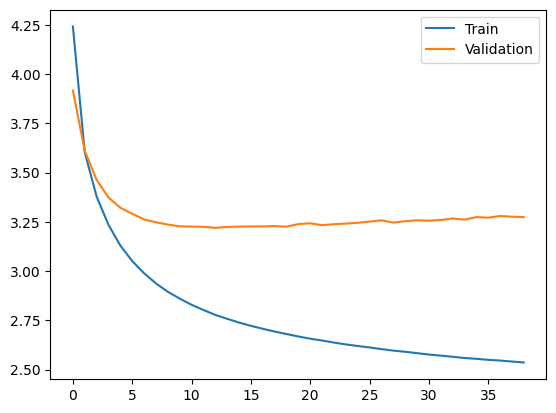

In [68]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

In [90]:
if isinstance(model, nn.DataParallel):
    mymodel = model.module
else:
    mymodel = model

In [91]:
def greedy_caption(feat, max_len=30):
    mymodel.eval()
    feat = feat.unsqueeze(0).to(device)
    h = mymodel.encoder(feat).unsqueeze(0)
    c = torch.zeros_like(h)

    word = torch.tensor([[stoi[START]]]).to(device)
    caption = []

    for _ in range(max_len):
        out, (h, c) = mymodel.decoder(word, (h, c))
        pred = out.argmax(-1)

        word = pred
        token = itos[pred.item()]

        if token == END:
            break

        caption.append(token)

    return " ".join(caption)


In [92]:
import heapq

def beam_search(feat, beam_width=3, max_len=30):
    mymodel.eval()
    feat = feat.unsqueeze(0).to(device)
    h = mymodel.encoder(feat).unsqueeze(0)
    c = torch.zeros_like(h)

    sequences = [(0, [stoi[START]], h, c)]

    for _ in range(max_len):
        all_candidates = []

        for score, seq, h, c in sequences:
            word = torch.tensor([[seq[-1]]]).to(device)
            out, (h_new, c_new) = mymodel.decoder(word, (h, c))
            probs = torch.log_softmax(out.squeeze(1), dim=-1)

            topk = torch.topk(probs, beam_width)

            for i in range(beam_width):
                token = topk.indices[0][i].item()
                new_score = score - topk.values[0][i].item()
                all_candidates.append((new_score, seq+[token], h_new, c_new))

        sequences = sorted(all_candidates, key=lambda x: x[0])[:beam_width]

    best_seq = sequences[0][1]
    return " ".join([itos[i] for i in best_seq if i not in [stoi[START], stoi[END], stoi[PAD]]])


In [106]:
## Eval
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu(model, sample_size=500):
    references = []
    hypotheses = []

    for img_id in random.sample(test_ids, min(sample_size, len(test_ids))):
        feat = torch.tensor(features_dict[img_id + ".jpg"]).float()
        pred = greedy_caption(feat).split()

        refs = [c.lower().split() for c in ImgToCap[img_id]]

        references.append(refs)
        hypotheses.append(pred)

    smoothie = SmoothingFunction().method1
    bleu4 = corpus_bleu(references, hypotheses, smoothing_function=smoothie)

    print(f"BLEU-4 Score: {bleu4:.4f}")

    return references, hypotheses

from sklearn.metrics import precision_score, recall_score, f1_score

from collections import Counter

def compute_token_metrics(references, hypotheses):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for refs, pred in zip(references, hypotheses):
        target = refs[0]

        pred_counts = Counter(pred)
        target_counts = Counter(target)

        # True positives
        tp = sum((pred_counts & target_counts).values())

        # False positives
        fp = sum(pred_counts.values()) - tp

        # False negatives
        fn = sum(target_counts.values()) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-8)
    recall = total_tp / (total_tp + total_fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")


In [107]:
references, hypotheses = compute_bleu(model, sample_size=2000)
compute_token_metrics(references, hypotheses)

BLEU-4 Score: 0.1589
Precision: 0.3895
Recall   : 0.2192
F1-Score : 0.2805


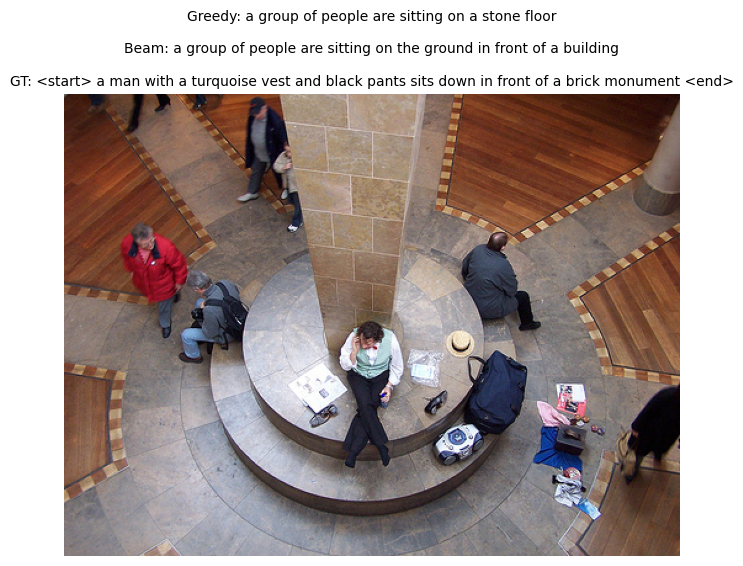

In [101]:
import matplotlib.pyplot as plt
from PIL import Image
import os

img_id = random.choice(test_ids)
# img_id = "1000523639"

# Load feature
feat = torch.tensor(features_dict[img_id + ".jpg"]).float()

# Generate captions
greedy_cap = greedy_caption(feat)
beam_cap = beam_search(feat)
gt_caps = ImgToCap[img_id]

# Load image
img_path = os.path.join(IMAGE_DIR, img_id + ".jpg")
image = Image.open(img_path).convert("RGB")

# Display
plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis("off")

plt.title(
    f"Greedy: {greedy_cap}\n\n"
    f"Beam: {beam_cap}\n\n"
    f"GT: {gt_caps[0]}",
    fontsize=10
)

plt.show()
